Santander Bank is running a competition in Kaggle. This notebook is an attempt to solve the problem.

In [58]:
import pandas as pd
import numpy as np
import scipy as sy
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('//tsclient/U/General/Stand/train.csv')

In [3]:
df_test = pd.read_csv('//tsclient/U/General/Stand/test.csv')

In [4]:
print("The number of features are : {0},& the number of instances are : {1}".format(df_train.shape[1],df_train.shape[0]))

The number of features are : 4993,& the number of instances are : 4459


That's a lot of features, infact there are more features than instances. Let's try to reduce the dimensionality by using the following methods,
1. Identify the features having high variance / standard deviation.
2. Identify features which exhibit strong corelation with the Target variable.
3. Using Random Forest, build large number of binary trees using a subset of features and identify the collective feature importance.

Inspired : https://www.kdnuggets.com/2015/05/7-methods-data-dimensionality-reduction.html

In [5]:
df_train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [6]:
ID = df_train['ID']
Y = df_train['target']

In [7]:
df_train.drop(['ID','target'],axis=1,inplace=True)

Using the scikit learn MinMax scaler to normalize the data 

In [9]:
tr = MinMaxScaler()

In [10]:
df_train_tr = tr.fit_transform(df_train.values)

In [11]:
df_train_des = pd.DataFrame(df_train_tr,columns=df_train.columns)

In [12]:
df_train_des = df_train.describe().T

In [13]:
df_train_des = df_train_des.reset_index().rename(columns={'index':'columns'})

In [14]:
df_train_des.head()

,columns,count,mean,std,min,25%,50%,75%,max
0,48df886f9,4459.0,14654.930101,3.893298e+05,0.0,0.0,0.0,0.0,20000000.0
1,0deb4b6a8,4459.0,1390.894819,6.428302e+04,0.0,0.0,0.0,0.0,4000000.0
2,34b15f335,4459.0,26722.450922,5.699652e+05,0.0,0.0,0.0,0.0,20000000.0
3,a8cb14b00,4459.0,4530.163714,2.359124e+05,0.0,0.0,0.0,0.0,14800000.0
4,2f0771a37,4459.0,26409.957390,1.514730e+06,0.0,0.0,0.0,0.0,100000000.0


To establish the 'Variance' for each feature:

In [15]:
df_train_des['Variance'] = df_train_des['columns'].apply(lambda x : np.var(df_train[x]))

In [16]:
print("Total features in the dataset is : {0}".format(df_train.shape[1]))
print("No of Columns having variance > Median is {0} ".format(len(df_train_des['columns'][df_train_des['Variance'] > df_train_des['Variance'].quantile(.50)])))
print("No of Columns having variance > 3rd quartile is {0} ".format(len(df_train_des['columns'][df_train_des['Variance'] > df_train_des['Variance'].quantile(.75)])))
print("No of Columns having variance > 85th percentile is {0} ".format(len(df_train_des['columns'][df_train_des['Variance'] > df_train_des['Variance'].quantile(.85)])))
print("No of Columns having variance > 95th percentile is {0} ".format(len(df_train_des['columns'][df_train_des['Variance'] > df_train_des['Variance'].quantile(.95)])))


Total features in the dataset is : 4991
No of Columns having variance > Median is 2495 
No of Columns having variance > 3rd quartile is 1248 
No of Columns having variance > 85th percentile is 749 
No of Columns having variance > 95th percentile is 250 


As we can see, the number of features exhibiting high variance (>95th percentile) is 250, 
i.e a 95% reduction. 

In [17]:
df_train_des['distinct_vals'] = df_train_des['columns'].apply(lambda x : len(df_train[x].value_counts()))

To establish the "Standard Deviation" & "Pearson's Correlation" for the features

In [18]:
#df_train_des['Mean'] = df_train_des['columns'].apply(lambda x : np.mean(df_train[x]))
df_train_des['Std_Dev'] = df_train_des['columns'].apply(lambda x : np.std(df_train[x]))
df_train_des['Corr'] = df_train_des['columns'].apply(lambda x : np.corrcoef(Y,df_train[x])[0][1])

To cover the possibility of majority of features being ordinal, lets calculate "Spearman rank correlation" 
for this dataset.

In [19]:
#(xranks, yranks)
import scipy.stats
df_train_des['Spearman_Corr'] = df_train_des['columns'].apply(lambda x : scipy.stats.pearsonr(Y,df_train[x])[0])

In [90]:
df_train_des['Std_Dev'].describe()

count    4.991000e+03
mean     2.899561e+06
std      4.458922e+06
min      0.000000e+00
25%      6.164478e+05
50%      1.706187e+06
75%      3.773485e+06
max      6.971865e+07
Name: Std_Dev, dtype: float64

In [21]:
print("Total features in the dataset is : {0}".format(df_train.shape[1]))
print("No of Columns having variance > Median is {0} ".format(len(df_train_des['columns'][df_train_des['Std_Dev'] > df_train_des['Std_Dev'].quantile(.50)])))
print("No of Columns having variance > 3rd quartile is {0} ".format(len(df_train_des['columns'][df_train_des['Std_Dev'] > df_train_des['Std_Dev'].quantile(.75)])))
print("No of Columns having variance > 85th percentile is {0} ".format(len(df_train_des['columns'][df_train_des['Std_Dev'] > df_train_des['Std_Dev'].quantile(.85)])))
print("No of Columns having variance > 95th percentile is {0} ".format(len(df_train_des['columns'][df_train_des['Std_Dev'] > df_train_des['Std_Dev'].quantile(.95)])))

Total features in the dataset is : 4991
No of Columns having variance > Median is 2495 
No of Columns having variance > 3rd quartile is 1248 
No of Columns having variance > 85th percentile is 749 
No of Columns having variance > 95th percentile is 250 


As we can see, the number of features exhibiting high Standard Deviation (>95th percentile) is 250, 
i.e a 95% reduction. 

In [22]:
df_train_des['Spearman_Corr'].describe()

count    4735.000000
mean        0.023465
std         0.053689
min        -0.051813
25%        -0.007194
50%         0.006248
75%         0.028457
max         0.273379
Name: Spearman_Corr, dtype: float64

In [23]:
df_train_des['Corr'].describe()

count    4735.000000
mean        0.023465
std         0.053689
min        -0.051813
25%        -0.007194
50%         0.006248
75%         0.028457
max         0.273379
Name: Corr, dtype: float64

Both Spearman rank correlation &  Pearson correlation exhibit similar distribution. Hence we can stick with either of 
them.

In [24]:
print("Total features in the dataset is : {0}".format(df_train.shape[1]))
print("No of Columns having Corr > Median is {0} ".format(len(df_train_des['columns'][df_train_des['Corr'] > df_train_des['Corr'].quantile(.50)])))
print("No of Columns having Corr > 3rd quartile is {0} ".format(len(df_train_des['columns'][df_train_des['Corr'] > df_train_des['Corr'].quantile(.75)])))
print("No of Columns having Corr > 85th percentile is {0} ".format(len(df_train_des['columns'][df_train_des['Corr'] > df_train_des['Corr'].quantile(.85)])))
print("No of Columns having Corr > 95th percentile is {0} ".format(len(df_train_des['columns'][df_train_des['Corr'] > df_train_des['Corr'].quantile(.95)])))

Total features in the dataset is : 4991
No of Columns having Corr > Median is 2367 
No of Columns having Corr > 3rd quartile is 1184 
No of Columns having Corr > 85th percentile is 711 
No of Columns having Corr > 95th percentile is 237 


In [25]:
print("Total features in the dataset is : {0}".format(df_train.shape[1]))
print("No of Columns having Spearman_Corr > Median is {0} ".format(len(df_train_des['columns'][df_train_des['Corr'] > df_train_des['Spearman_Corr'].quantile(.50)])))
print("No of Columns having Spearman_Corr > 3rd quartile is {0} ".format(len(df_train_des['columns'][df_train_des['Corr'] > df_train_des['Spearman_Corr'].quantile(.75)])))
print("No of Columns having Spearman_Corr > 85th percentile is {0} ".format(len(df_train_des['columns'][df_train_des['Corr'] > df_train_des['Spearman_Corr'].quantile(.85)])))
print("No of Columns having Spearman_Corr > 95th percentile is {0} ".format(len(df_train_des['columns'][df_train_des['Corr'] > df_train_des['Spearman_Corr'].quantile(.95)])))

Total features in the dataset is : 4991
No of Columns having Spearman_Corr > Median is 2368 
No of Columns having Spearman_Corr > 3rd quartile is 1184 
No of Columns having Spearman_Corr > 85th percentile is 711 
No of Columns having Spearman_Corr > 95th percentile is 237 


In [26]:
col_stddev = list(df_train_des['columns'][df_train_des['Std_Dev'] > df_train_des['Std_Dev'].quantile(.95)])

In [27]:
col_corr = list(df_train_des['columns'][df_train_des['Corr'] > df_train_des['Corr'].quantile(.95)])

In [28]:
col_spearman_corr = list(df_train_des['columns'][df_train_des['Spearman_Corr'] > df_train_des['Spearman_Corr'].quantile(.95)])

In [29]:
# Intersection of features having high Standard Deviation & Correlation to the target
fea_intersect = list(set.intersection(set(col_stddev),set(col_corr)))

If we take the union of features having higher standard deviation & Correlation, we have 463 features, 
this  a 91% reduction from the original feature set(4993)

In [30]:
fea_union = list(set.union(set(col_stddev),set(col_corr)))

In [293]:
pd.DataFrame(fea_union).to_csv('//tsclient/U/General/Stand/feature_union.csv',index=False)

In [31]:
# Filtering the train & test based on the intersection of features
df_train_sample_intersect = df_train.filter(items=fea_intersect)
df_test_sample_intersect = df_test.filter(items=fea_intersect)

In [32]:
df_train_sample_inter_tr = tr.fit_transform(df_train_sample_intersect.values)
df_test_sample_inter_tr = tr.fit_transform(df_test_sample_intersect.values)

In [33]:
# Filtering the train & test based on the UNION of features
df_train_sample_union = df_train.filter(items=fea_union)
df_test_sample_union = df_test.filter(items=fea_union)

In [34]:
df_train_sample_un_tr = tr.fit_transform(df_train_sample_union.values)
df_test_sample_un_tr = tr.transform(df_test_sample_union.values)

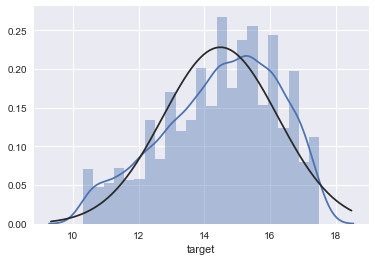

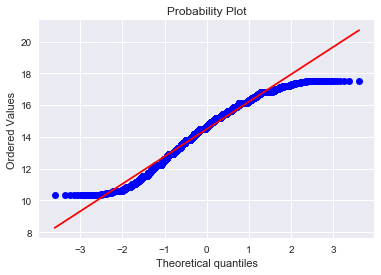

In [45]:
log_Y = np.log(Y)
sns.distplot(log_Y,fit=norm);
fig = plt.figure()
res = stats.probplot(log_Y, plot=plt)

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from time import time

In [36]:
grid_param_grid = {"n_estimators": [200, 500,1000],
    "max_depth": [3, None],
    "max_features": [1, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [True, False],
    "criterion" :['mse','mae']}

In [37]:
model = RandomForestRegressor(random_state=10)

In [39]:
n_iter_search = 20

In [42]:
grid_search = RandomizedSearchCV(estimator=model,param_distributions=grid_param_grid,n_iter=n_iter_search,scoring='mean_squared_error')

In [43]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [78]:
del X_train, X_val, y_train, y_val

In [79]:
X_train, X_val, y_train, y_val = train_test_split(df_train_sample_un_tr, log_Y, test_size = 0.2, random_state = 0)

In [80]:
start = time()

In [81]:
grid_search.fit(X_train,y_train)
print("GridSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(grid_search.cv_results_)

GridSearchCV took 5308.98 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -2.170 (std: 0.078)
Parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 1, 'max_depth': None, 'criterion': 'mae', 'bootstrap': False}

Model with rank: 2
Mean validation score: -2.176 (std: 0.072)
Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 3, 'max_depth': None, 'criterion': 'mae', 'bootstrap': False}

Model with rank: 3
Mean validation score: -2.200 (std: 0.088)
Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 5, 'max_depth': None, 'criterion': 'mse', 'bootstrap': False}



In [82]:
y_pred_val = grid_search.predict(X_val)

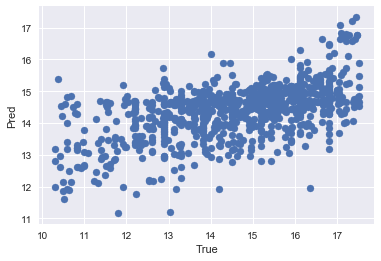

In [63]:
plt.scatter(y_val, y_pred_val)
plt.xlabel("True")
plt.ylabel("Pred")

In [64]:
from sklearn import metrics  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred_val)))

Root Mean Squared Error: 1.44219455275


In [83]:
log_ypred = grid_search.predict(df_test_sample_un_tr)

In [84]:
ypred = np.exp(log_ypred)
ID = df_test['ID']

In [85]:
sub = pd.DataFrame({'ID':ID,'target':ypred})

In [86]:
sub.to_csv('//tsclient/U/General/Stand/submission__aug_05_0.1.csv',index=False)

If we submit the above file, we get a score of 1.54 (topper is @ 0.47), 
which isnt bad considering the minimum effort we had put in and the choice of algorithm.

Now re-training on the entire dataset

In [72]:
grid_search.fit(df_train_sample_un_tr,log_Y)
print("GridSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(grid_search.cv_results_)

GridSearchCV took 12108.42 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -2.117 (std: 0.120)
Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 10, 'max_depth': None, 'criterion': 'mae', 'bootstrap': False}

Model with rank: 2
Mean validation score: -2.133 (std: 0.119)
Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 3, 'max_depth': None, 'criterion': 'mae', 'bootstrap': False}

Model with rank: 3
Mean validation score: -2.150 (std: 0.104)
Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 5, 'max_depth': None, 'criterion': 'mse', 'bootstrap': False}



In [74]:
log_ypred = grid_search.predict(df_test_sample_un_tr)

In [75]:
ypred = np.exp(log_ypred)
ID = df_test['ID']

In [77]:
sub = pd.DataFrame({'ID':ID,'target':ypred})
sub.to_csv('//tsclient/U/General/Stand/submission__aug_05_0.2.csv',index=False)

If we submit the above file, we get a score of 1.51 (topper is @ 0.47), 
which isnt bad considering the minimum effort we had put in and the choice of algorithm.